<a href="https://colab.research.google.com/github/SJkzk/Hypo_Adverse_ML/blob/main/Non_invasive_in_and_post_induction_hypotension_PPF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [133]:
import sklearn
import pandas as pd
import numpy as np
import scipy.signal as sp
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None # 禁用了Hypo_Label(1）中的链式警告
from google.colab import drive
drive.mount('/content/drive')

df_clinical = pd.read_csv('https://api.vitaldb.net/cases') # 0~6387 entries, clinical info
df_clinical['IndcStart'] = None 
df_clinical['IndcEnd'] = None 
TracksList = pd.read_csv('https://api.vitaldb.net/trks') # ids of tracks 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[3, 5, 7, 8, 9, 13, 14, 16, 17, 19, 20, 22, 28, 29, 30, 31, 34, 35, 36, 37, 38, 40, 42, 44, 45, 46, 47, 48, 50, 52, 54, 55, 57, 59, 60, 67, 68, 69, 70, 72, 74, 75, 77, 78, 81, 83, 88, 93, 97, 101, 103, 104, 106, 109, 111, 113, 118, 119, 121, 122, 124, 125, 126, 128, 129, 132, 134, 136, 137, 138, 139, 140, 141, 143, 147, 149, 151, 152, 153, 154, 156, 158, 160, 163, 165, 166, 167, 169, 171, 172, 177, 180, 181, 182, 187, 192, 193, 194, 195, 199, 200, 202, 203, 204, 205, 208, 210, 211, 212, 214, 215, 216, 218, 219, 221, 222, 223, 225, 226, 227, 229, 231, 235, 236, 237, 240, 241, 245, 246, 247, 248, 251, 253, 257, 258, 259, 260, 261, 262, 263, 267, 268, 274, 276, 277, 281, 284, 285, 286, 290, 291, 292, 293, 295, 296, 297, 298, 301, 302, 305, 306, 308, 309, 310, 311, 314, 316, 317, 318, 319, 320, 321, 322, 324, 325, 326, 329, 330, 332, 334, 335, 336, 338, 341, 342,

In [215]:
ids = range(1,200)  
CaseId_Valid_PPF= [] 
PPF_trks = []
for theid in ids:
  if "Orchestra/PPF20_RATE" in TracksList[TracksList['caseid'] == theid]['tname'].values:
    CaseId_Valid_PPF.append(theid)
print(CaseId_Valid_PPF)

CaseId_Valid_NIBP= [] 
for theid in ids:
  if "Solar8000/NIBP_SBP" in TracksList[TracksList['caseid'] == theid]['tname'].values:
    CaseId_Valid_NIBP.append(theid)
print(CaseId_Valid_NIBP)

index =[val for val in CaseId_Valid_PPF if val in CaseId_Valid_NIBP]
print(index) 
print('number of valid cases: ',len(index))

def valid_Cases(theid):
  id1 = TracksList[(TracksList['tname'] == "Orchestra/PPF20_RATE") & (TracksList['caseid'] == theid)]['tid'].values[0]
  Wv_PPF_rate = pd.read_csv("https://api.vitaldb.net/"+id1)
  id2 = TracksList[(TracksList['tname'] == "Solar8000/NIBP_SBP") & (TracksList['caseid'] == theid)]['tid'].values[0]
  Wv_NI_SBP = pd.read_csv("https://api.vitaldb.net/"+id2)
  Wv_NI_SBP = Wv_NI_SBP.loc[::30*3]

  if ( Wv_PPF_rate['Orchestra/PPF20_RATE'] == 0.0).all():
    return False
  if Wv_NI_SBP['Time'].values[0] > Wv_PPF_rate['Orchestra/PPF20_RATE'].to_numpy().nonzero()[0][0]:
    return False

  opstart = df_clinical[df_clinical['caseid'] == theid]['opstart'].values[0]
  num_valid_BP = len(Wv_NI_SBP[ Wv_NI_SBP['Time'] <= opstart+900]) # 900s = 15min
  num_ideal_BP = (opstart+900)/(60*3)
  if num_valid_BP < num_ideal_BP*0.8:
    return False #16 is invalid
  else:
    return True

valid_index = index.copy()
for i in index:
  if not valid_Cases(i):
    valid_index.remove(i)
print(valid_index)
print('number of valid cases: ',len(valid_index))
# valid_Cases(47)

[3, 5, 7, 8, 9, 13, 14, 16, 17, 19, 20, 22, 28, 29, 30, 31, 34, 35, 36, 37, 38, 40, 42, 44, 45, 46, 47, 48, 50, 52, 54, 55, 57, 59, 60, 67, 68, 69, 70, 72, 74, 75, 77, 78, 81, 83, 88, 93, 97, 101, 103, 104, 106, 109, 111, 113, 118, 119, 121, 122, 124, 125, 126, 128, 129, 132, 134, 136, 137, 138, 139, 140, 141, 143, 147, 149, 151, 152, 153, 154, 156, 158, 160, 163, 165, 166, 167, 169, 171, 172, 177, 180, 181, 182, 187, 192, 193, 194, 195, 199]
[1, 2, 3, 5, 6, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 131, 133, 134, 135, 137, 139, 140, 141, 142, 143, 144, 145, 14

#Preprocess - PPF
selet limited colomns for test, and add extracted induction info


In [ ]:
df_test = df_clinical.loc[[x-1 for x in index]][['caseid','sex','age','bmi','height','department',]][df_clinical['department'] == 'General surgery']
df_test["time"] = None
df_test["PPF_for_dose"] = 0
df_test["PPF_next_dose"] = None
# df_test.loc[2]['sex']

In [163]:
np.save('/content/drive/My Drive/Colab Notebooks/outindex.npy',valid_index)
index = np.load('/content/drive/My Drive/Colab Notebooks/outindex.npy')
index

array([  3,   8,   9,  14,  30,  34,  35,  36,  37,  40,  45,  47,  48,
        54,  57,  70,  72,  78,  81,  88, 106, 109, 121, 122, 129, 141,
       147, 151, 154, 165, 169, 171, 172, 180, 181, 182, 192, 193, 204,
       205, 211, 212, 214, 215, 219, 223, 225, 226, 227, 231, 235, 240,
       245, 248, 253, 257, 259, 260, 261, 262, 267, 276, 277, 285, 290,
       291, 292, 298, 301, 302, 305, 309, 310, 311, 314, 317, 320, 322,
       326, 329, 334, 335, 336, 338, 341, 343, 344, 351, 352, 356, 360,
       364, 365, 369, 372, 373, 378, 379, 381, 393, 394, 400, 403, 410,
       412, 414, 422, 423, 424, 426, 428, 429, 430, 432, 434, 436, 443,
       444, 450, 453, 454, 456, 457, 459, 465, 466, 467, 470, 471, 479,
       480, 482, 489, 491, 493, 494, 498])

In [56]:
def constant_split(lis): # 寻找每次注射
  stack = []
  sta = []
  end = []
  flag = -1
  for i,n in enumerate(lis):
    if (flag==-1 and n==0) or (flag==1 and 6000>n>0):
      stack.append(i)
    if (flag==-1 and 6000>n>0):
      stack.append(i)
      sta.append(i)
      flag = 1
    if (flag==1 and n==0):
      end.append(stack.pop())
      flag = -1
  return sta,end

# NIBP OR SIMULATION
def PPF_INFO(theid):
  id = TracksList[(TracksList['tname'] == "Orchestra/PPF20_RATE") & (TracksList['caseid'] == theid)]['tid'].values[0]
  Wv_PPF_rate = pd.read_csv("https://api.vitaldb.net/"+id)

  opstart = df_clinical[df_clinical['caseid'] == theid]['opstart'].values[0]
  # if (Wv_PPF_rate['Orchestra/PPF20_RATE'] == 0.0).all():
  #   return False

# # ########很粗糙要改
#   peak_pro = Wv_PPF_rate.copy()
#   for i in range(len(peak_pro)):
#     if peak_pro['Orchestra/PPF20_RATE'][i]>100: # "num" is a "large dose" threshold
#       peak_pro['Orchestra/PPF20_RATE'][i] = 150
#   # plt.plot(peak_pro['Time'],peak_pro['Orchestra/PPF20_RATE'])

#   peaks, properties = sp.find_peaks(peak_pro['Orchestra/PPF20_RATE'],height=100,width=5)

#   Indct_sta = peak_pro['Time'][[int(x) for x in properties['left_ips']]].values
#   Indct_end = peak_pro['Time'][[int(x) for x in properties['right_ips']]].values
#   Indct_sta = [x for x in Indct_sta if x < opstart]
#   Indct_end = Indct_end[:len(Indct_sta)]

  i1,i2 = constant_split(Wv_PPF_rate['Orchestra/PPF20_RATE'].values.tolist())
  Indct_sta = Wv_PPF_rate['Time'][[int(x) for x in i1]].values
  Indct_end = Wv_PPF_rate['Time'][[int(x) for x in i2]].values
  Indct_sta = [x for x in Indct_sta if x < opstart]
  Indct_end = Indct_end[:len(Indct_sta)]

  INFO = {}
  INFO["indsta"] = Indct_sta
  INFO["indend"] = Indct_end
  INFO["opsta"] = opstart 
  # time_min = (Indct_end - Indct_sta) 
  return INFO

PPF_INFO(40)
# 291, 187有问题

{'indsta': [129.85099983215332, 229.621000289917, 835.7449998855591],
 'indend': array([ 149.65400028,  676.24399996, 2969.19999981]),
 'opsta': 1278}

array([  38,   39,   40, ..., 7736, 7737, 7738])

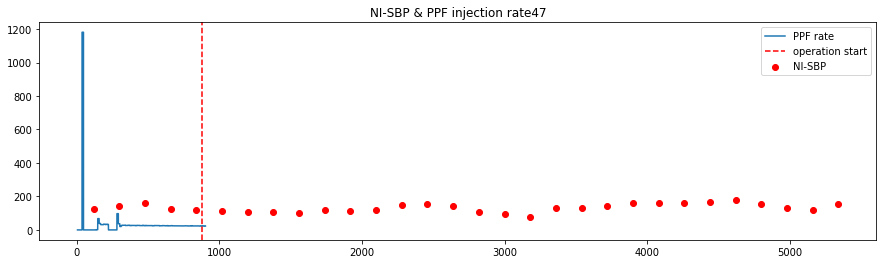

In [213]:
from prompt_toolkit.history import DummyHistory
# Draw and show
theid = 47
id1 = TracksList[(TracksList['tname'] == "Orchestra/PPF20_RATE") & (TracksList['caseid'] == theid)]['tid'].values[0]
Wv_PPF_rate = pd.read_csv("https://api.vitaldb.net/"+id1)

opstart = df_clinical[df_clinical['caseid'] == theid]['opstart'].values[0]
# Original Figure
range_see = 1200
plt.figure(figsize=(15,4))
plt.title('NI-SBP & PPF injection rate'+str(theid))
plt.plot(Wv_PPF_rate['Time'][:range_see],Wv_PPF_rate['Orchestra/PPF20_RATE'][:range_see], label='PPF rate')
# plt.plot(Wv_NI_SBP['Time'],Wv_NI_SBP['Solar8000/NIBP_SBP'])
# plt.ylim((0,600))
# plt.axvline(opstart,color='r',linestyle='--')
# plt.plot(peak_pro['Time'][peaks], peak_pro['Orchestra/PPF20_RATE'][peaks],'x',color='r')
# plt.plot(peaks, peak_pro['Orchestra/PPF20_RATE'][peaks],'x',color='r')
id2 = TracksList[(TracksList['tname'] == "Solar8000/NIBP_SBP") & (TracksList['caseid'] == theid)]['tid'].values[0]
Wv_NI_SBP = pd.read_csv("https://api.vitaldb.net/"+id2)
Wv_NI_SBP = Wv_NI_SBP.loc[::30*3]
range_see = 30
plt.scatter(Wv_NI_SBP['Time'][:range_see],Wv_NI_SBP['Solar8000/NIBP_SBP'][:range_see],color='r',label='NI-SBP')
plt.axvline(opstart,color='r',linestyle='--',label='operation start')
range_see = 2000
plt.legend()

# Wv_NI_SBP
# Wv_NI_SBP['Time'].values[0] 


<BarContainer object of 10 artists>

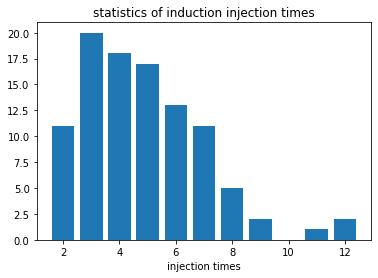

In [53]:
num_inject = []
show = {}
for cases in index[:100]:
  if PPF_INFO(cases):
    dummy = PPF_INFO(cases)
    num_inject.append(len(dummy["indsta"]))
for item in set(num_inject): 
  show[item] = num_inject.count(item)
plt.figure()
plt.title('statistics of induction injection times')
plt.xlabel('injection times')
plt.bar(*zip(*show.items()))

In [198]:
df_reframe = pd.DataFrame(columns = ['caseid','sex','age','bmi','height','department','time','PPF_for_dose','PPF_next_dose'])

def PPF_dose(df,theid):
  """
  detect protofol dosage at every injection.
  """
  id = TracksList[(TracksList['tname'] == "Orchestra/PPF20_VOL") & (TracksList['caseid'] == theid)]['tid'].values[0]
  VOL_PPF = pd.read_csv("https://api.vitaldb.net/"+id)
  # if not PPF_INFO(theid):
  #   return False
  # else:    
  PPF_time = PPF_INFO(theid)
  for i in range(len(PPF_time["indsta"])):
    dummy = pd.DataFrame()
    dummy = df_test[df_test["caseid"] == theid].copy()
    dummy["time"] = PPF_time["indsta"][i]
    statime = PPF_time["indsta"][i]
    t = (VOL_PPF.loc[abs(VOL_PPF['Time'] - statime) < 0.1].index[0]-1)
    tt = 0 if t< 0 else t
    dummy["PPF_for_dose"] = VOL_PPF.loc[tt]["Orchestra/PPF20_VOL"]

    endtime = PPF_time["indend"][i]
    dummy["PPF_next_dose"] = VOL_PPF.loc[VOL_PPF.loc[abs(VOL_PPF['Time'] - endtime) < 0.1].index[0]+1]["Orchestra/PPF20_VOL"]
    df = df.append(dummy,ignore_index=True)
  return df

for cases in index:
  df_reframe = PPF_dose(df_reframe,cases)
df_reframe.head()
# df_reframe = PPF_dose(df_reframe,8)

,caseid,sex,age,bmi,height,department,time,PPF_for_dose,PPF_next_dose
0,3,M,62.0,24.4,169.1,General surgery,182.3823,0.000,4.897000
1,3,M,62.0,24.4,169.1,General surgery,292.4873,4.897,6.392000
2,3,M,62.0,24.4,169.1,General surgery,466.6463,6.392,7.005000
3,3,M,62.0,24.4,169.1,General surgery,551.7313,7.005,21.941999
4,8,F,81.0,27.4,156.7,General surgery,25.1740,5.882,8.002000


#Preprocess - BP drop

先做最简单的，先对照着这些时间点直接写上15min后的血压

In [199]:
index_BPbreak = []
def FindBPpoint(NBP,ttarget):
  """
  find a proper BP measuremnt for each row in dataframe
  """
  sta =[]
  for t in NBP['Time'].values:
    if t < ttarget:
      sta.append(t)
    else:
      tmeas = sta.pop()
      break
  if ttarget - tmeas > 200: # if measurement is too far to be valid
    return False
  return tmeas

def NIBP_data(df_caseslice,theid):
  id = TracksList[(TracksList['tname'] == "Solar8000/NIBP_SBP") & (TracksList['caseid'] == theid)]['tid'].values[0]
  Wv_NI_SBP = pd.read_csv("https://api.vitaldb.net/"+id)
  Wv_NI_SBP = Wv_NI_SBP.loc[::30*3]

  subindex = df_caseslice.index
  for i in range(len(df_caseslice)):
    if not FindBPpoint(Wv_NI_SBP,df_caseslice['time'].values[i]):
      index_BPbreak.append(theid)
      return False
    else:
      t = FindBPpoint(Wv_NI_SBP,df_caseslice['time'].values[i])
      print(theid,i,t)
      print(Wv_NI_SBP[Wv_NI_SBP['Time'] == t]['Solar8000/NIBP_SBP'])
      df_caseslice['CurrentNIBP'][subindex[i]] = Wv_NI_SBP[Wv_NI_SBP['Time'] == t]['Solar8000/NIBP_SBP'].values[0]
  return df_caseslice

df_reframe['CurrentNIBP'] = None
df_reframe['Af15minNIBP'] = None
df_reframe2 = pd.DataFrame()

for cases in index:
  del dummy
  dummy = NIBP_data(df_reframe[df_reframe['caseid'] == cases],cases)
  if dummy is not False:
    df_reframe2 = df_reframe2.append(dummy,ignore_index=True)
df_reframe2
# NIBP_data(df_reframe[df_reframe['caseid'] == 48],48)
# FindBPpoint(df_reframe[df_reframe['caseid']],1000)

3 0 49.5691
0    136
Name: Solar8000/NIBP_SBP, dtype: int64
3 1 229.558
90    130
Name: Solar8000/NIBP_SBP, dtype: int64
3 2 409.58
180    87
Name: Solar8000/NIBP_SBP, dtype: int64
3 3 409.58
180    87
Name: Solar8000/NIBP_SBP, dtype: int64
8 0 3.95881
0    184
Name: Solar8000/NIBP_SBP, dtype: int64
8 1 183.985
90    113
Name: Solar8000/NIBP_SBP, dtype: int64
8 2 492.014
180    81
Name: Solar8000/NIBP_SBP, dtype: int64
9 0 1.858
0    132
Name: Solar8000/NIBP_SBP, dtype: int64
9 1 181.874
90    117
Name: Solar8000/NIBP_SBP, dtype: int64
9 2 361.891
180    118
Name: Solar8000/NIBP_SBP, dtype: int64
9 3 541.908
270    146
Name: Solar8000/NIBP_SBP, dtype: int64
14 0 23.3457
0    141
Name: Solar8000/NIBP_SBP, dtype: int64
14 1 23.3457
0    141
Name: Solar8000/NIBP_SBP, dtype: int64
14 2 203.376
90    123
Name: Solar8000/NIBP_SBP, dtype: int64
14 3 383.393
180    108
Name: Solar8000/NIBP_SBP, dtype: int64
30 0 3.656
0    157
Name: Solar8000/NIBP_SBP, dtype: int64
30 1 3.656
0    157
Name: So

IndexError: ignored

In [191]:
# Wv_NI_SBP[Wv_NI_SBP['Time'] == 3.95881]['Solar8000/NIBP_SBP'].values[0]
# Wv_NI_SBP
index_BPbreak
index
id = TracksList[(TracksList['tname'] == "Solar8000/NIBP_SBP") & (TracksList['caseid'] == 48)]['tid'].values[0]
id

'c54b9638a332492abf0094e1954e3d408e77ff83'